# 🎓 Examen Final: SQL y Gestión de Datos (15 Puntos)

**Contexto:** Eres el Data Steward de la **Universidad Santo Tomás**. Se acerca el cierre de semestre y la decanatura requiere una gestión intensiva de la base de datos: desde registrar ofertas de última hora hasta generar los indicadores finales de deserción y carga académica.

**Instrucciones:**
* Asegúrate de tener el archivo **`universidad.db`** en esta misma carpeta.
* Cada punto tiene un valor de **1.0** sobre 15.
* Usa `conn.commit()` después de las sentencias de modificación (INSERT/UPDATE/DELETE).
* Usa `pd.read_sql_query` para las consultas de selección (SELECT).

---

In [11]:
# 🛠️ CONFIGURACIÓN INICIAL
import sqlite3
import pandas as pd
import os

db_filename = r"C:\Users\jacks\OneDrive\Escritorio\tareaBD\Datos\universidad.db"

if not os.path.exists(db_filename):
    print(f"⚠️ ERROR: No encuentro '{db_filename}'. Súbelo a esta carpeta.")
else:
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()
    cursor.execute("PRAGMA foreign_keys = ON;")
    print(f"✅ Conectado a '{db_filename}'. ¡Listo para el examen!")
    
    cursor.execute("PRAGMA table_info(Inscripciones)")
print(cursor.fetchall())


✅ Conectado a 'C:\Users\jacks\OneDrive\Escritorio\tareaBD\Datos\universidad.db'. ¡Listo para el examen!
[(0, 'id_inscripcion', 'INTEGER', 0, None, 1), (1, 'id_estudiante', 'INTEGER', 0, None, 0), (2, 'id_curso', 'INTEGER', 0, None, 0), (3, 'fecha_inscripcion', 'DATE', 0, None, 0), (4, 'nota_final', 'REAL', 0, None, 0)]


## 📝 Sección 1: Gestión Académica (DML) - 5 Puntos

**1. Apertura de Curso (INSERT)**
La facultad abre un nuevo curso electivo.
* Inserta en la tabla `Cursos`:
    * Nombre: **'Big Data & AI'**
    * Créditos: **5**
    * ID Profesor: **20**

**2. Nuevo Ingreso (INSERT)**
Registra a un nuevo estudiante en la tabla `Estudiantes`:
    * Nombre: **'Lionel'**
    * Apellido: **'Messi'**
    * Email: **'lio@usta.edu.co'**
    * Fecha Ingreso: '2024-11-25'

**3. Matrícula Manual (INSERT)**
Matricula al estudiante 'Lionel Messi' en el curso de 'Big Data & AI' que acabas de crear.
* *Pista:* Necesitarás averiguar primero qué ID le asignó la base de datos a Lionel y al curso.
* Nota final: `NULL`.

**4. Corrección de Créditos (UPDATE)**
El comité curricular decidió que 5 créditos es demasiado.
* Actualiza el curso 'Big Data & AI' para que tenga **3 créditos**.

**5. Retiro Definitivo (DELETE)**
El estudiante con **ID = 10** se retira de la universidad.
* Elimina todos sus registros de la tabla `Inscripciones` (para mantener la integridad, primero borramos sus clases).

In [17]:
# Espacio para Código DML (Recuerda hacer commit)
# 1. Apertura de Curso (INSERT)
cursor.execute("""
    INSERT INTO Cursos (nombre_curso, creditos, id_profesor)
    VALUES ('Big Data & AI', 5, 20)
""")
conn.commit()

# 2. Nuevo Ingreso (INSERT)
cursor.execute("""
    INSERT INTO Estudiantes (Nombre, Apellido, Email, Fecha_Ingreso)
    VALUES ('Lionel', 'Messi', 'lio@usta.edu.co', '2024-11-25')
""")
conn.commit()

# 3. Matrícula Manual (INSERT)
# Obtener ID de Lionel Messi
lio_id = cursor.execute("SELECT ID_Estudiante FROM Estudiantes WHERE Nombre = 'Lionel' AND Apellido = 'Messi'").fetchone()[0]

# Obtener ID del curso 'Big Data & AI'
curso_id = cursor.execute("SELECT id_curso FROM Cursos WHERE nombre_curso = 'Big Data & AI'").fetchone()[0]

# Insertar matrícula
already = cursor.execute("""
    SELECT 1 FROM inscripciones
    WHERE id_estudiante = ? AND id_curso = ?
""", (lio_id, curso_id)).fetchone()

if not already:
    cursor.execute("""
        INSERT INTO inscripciones (id_estudiante, id_curso, nota_final)
        VALUES (?, ?, NULL)
    """, (lio_id, curso_id))
conn.commit()

# 4. Corrección de Créditos (UPDATE)
cursor.execute("""
    UPDATE Cursos
    SET creditos = 3
    WHERE nombre_curso = 'Big Data & AI'
""")
conn.commit()

# 5. Retiro Definitivo (DELETE)
# Primero borrar inscripciones del estudiante ID = 10
cursor.execute("DELETE FROM Inscripciones WHERE ID_Estudiante = 10")
conn.commit()

## 🔍 Sección 2: Consultas SQL (Analysis) - 6 Puntos

**6. Métricas Generales (Agregación)**
Calcula y muestra:
* Cantidad total de estudiantes.
* Cantidad total de cursos ofertados.
* Promedio de créditos de los cursos.

**7. Auditoría de Profesores (LEFT JOIN)**
Necesitamos ver la carga laboral completa.
* Lista **todos** los profesores (Nombre y Apellido) y el curso que dictan.
* **Condición:** Deben aparecer los profesores que **NO** tienen cursos asignados actualmente (valor NULL).

**8. Popularidad (GROUP BY)**
* Genera una lista con el `Nombre del Curso` y la **Cantidad de Estudiantes** inscritos en él.
* Ordena del más popular al menos popular.

**9. Cursos Masivos (HAVING)**
* Basado en la consulta anterior, filtra para mostrar solo los cursos que tienen **más de 20 estudiantes** inscritos.

**10. Búsqueda Inteligente (Subconsulta)**
* Obtén el nombre y apellido de los estudiantes inscritos en el curso **"Bases de Datos"**.
* **Reto:** No uses el ID=1 directamente. Usa una subconsulta `(SELECT id_curso FROM Cursos WHERE nombre_curso = 'Bases de Datos')`.

**11. Sábana de Notas (INNER JOIN Múltiple)**
* Genera un reporte detallado que contenga:
    * Nombre Estudiante | Apellido Estudiante | Nombre Curso | Nota Final | Nombre Profesor

In [25]:
# Espacio para Consultas SQL
# 6. Métricas Generales (Agregación)
q6 = pd.read_sql_query("""
    SELECT  (SELECT COUNT(*) FROM estudiantes)  AS total_estudiantes,
            (SELECT COUNT(*) FROM cursos)       AS total_cursos,
            (SELECT AVG(creditos) FROM cursos)  AS promedio_creditos
""", conn)
print("6. Métricas Generales"); display(q6)

# 7. Auditoría de Profesores (LEFT JOIN)
q7 = pd.read_sql_query("""
    SELECT  p.nombre        AS nombre_profesor,
            p.apellido      AS apellido_profesor,
            c.nombre_curso  AS curso
    FROM profesores p
    LEFT JOIN cursos c ON p.id_profesor = c.id_profesor
    ORDER BY p.apellido, p.nombre;
""", conn)
print("7. Auditoría de Profesores"); display(q7)
# 8. Popularidad (GROUP BY)
q8 = pd.read_sql_query("""
    SELECT  c.nombre_curso,
            COUNT(i.id_estudiante) AS cantidad_estudiantes
    FROM cursos c
    JOIN inscripciones i ON c.id_curso = i.id_curso
    GROUP BY c.nombre_curso
    ORDER BY cantidad_estudiantes DESC;
""", conn)
print("8. Popularidad"); display(q8)

# 9. Cursos Masivos (HAVING)
q9 = pd.read_sql_query("""
    SELECT  c.nombre_curso,
            COUNT(i.id_estudiante) AS cantidad_estudiantes
    FROM cursos c
    JOIN inscripciones i ON c.id_curso = i.id_curso
    GROUP BY c.nombre_curso
    HAVING COUNT(i.id_estudiante) > 20
    ORDER BY cantidad_estudiantes DESC;
""", conn)
print("9. Cursos Masivos"); display(q9)

# 10.Búsqueda Inteligente (Subconsulta)
q10 = pd.read_sql_query("""
    SELECT  e.nombre,
            e.apellido
    FROM estudiantes e
    WHERE e.id_estudiante IN (
        SELECT i.id_estudiante
        FROM inscripciones i
        WHERE i.id_curso = (
            SELECT id_curso
            FROM cursos
            WHERE nombre_curso = 'Bases de Datos'
        )
    );
""", conn)
print("10. Búsqueda Inteligente"); display(q10)
# 11.Sábana de Notas (INNER JOIN Múltiple)
q11 = pd.read_sql_query("""
    SELECT  e.nombre      AS nombre_estudiante,
            e.apellido    AS apellido_estudiante,
            c.nombre_curso,
            i.nota_final  AS nota_final,
            p.nombre      AS nombre_profesor
    FROM inscripciones i
    JOIN estudiantes e ON e.id_estudiante = i.id_estudiante
    JOIN cursos      c ON c.id_curso      = i.id_curso
    JOIN profesores  p ON p.id_profesor   = c.id_profesor
    ORDER BY c.nombre_curso, e.apellido, e.nombre;
""", conn)
print("11. Sábana de Notas"); display(q11)

6. Métricas Generales


,total_estudiantes,total_cursos,promedio_creditos
0,511,111,2.72973


7. Auditoría de Profesores


,nombre_profesor,apellido_profesor,curso
0,Oscar,Cardenas,Historia III
1,Diego,Castillo,Estadística Avanzado
2,Diego,Castillo,Álgebra Básico
3,Paula,Castillo,Sociología Teórico
4,Ana,Diaz,Inglés II
...,...,...,...
117,Beatriz,Zainea,Sociología Teórico
118,Valeria,Zainea,Derecho Teórico
119,Valeria,Zainea,Filosofía Básico
120,Valeria,Zainea,Álgebra Básico


8. Popularidad


,nombre_curso,cantidad_estudiantes
0,Economía Avanzado,103
1,Ética Avanzado,83
2,Bases de Datos,70
3,Inglés Avanzado,62
4,Inglés III,61
...,...,...
59,Historia Avanzado,14
60,Estadística I,13
61,Arte I,13
62,Física Avanzado,12


9. Cursos Masivos


,nombre_curso,cantidad_estudiantes
0,Economía Avanzado,103
1,Ética Avanzado,83
2,Bases de Datos,70
3,Inglés Avanzado,62
4,Inglés III,61
5,Historia III,60
6,Derecho Avanzado,60
7,Biología I,60
8,Estadística Teórico,46
9,Sociología Teórico,43


10. Búsqueda Inteligente


,nombre,apellido
0,Diego,Martinez
1,Lucia,Zainea
2,Oscar,Mora
3,Fernando,Zainea
4,Valeria,Maya
...,...,...
65,David,Martinez
66,Nicolas,Mora
67,Hector,Ortega
68,Hector,Martinez


11. Sábana de Notas


,nombre_estudiante,apellido_estudiante,nombre_curso,nota_final,nombre_profesor
0,Ivan,Cardenas,Arte Aplicado,4.3,Lucia
1,Lucia,Cardenas,Arte Aplicado,2.1,Lucia
2,Marta,Jimenez,Arte Aplicado,4.6,Lucia
3,Ana,Lopez,Arte Aplicado,3.2,Lucia
4,Felipe,Lopez,Arte Aplicado,4.1,Lucia
...,...,...,...,...,...
2019,Mariana,Silva,Ética III,2.6,Andres
2020,Sofia,Silva,Ética III,4.6,David
2021,Paula,Torres,Ética III,2.7,David
2022,Paula,Vargas,Ética III,3.0,David


## 📊 Sección 3: Analítica con Python (Pandas) - 4 Puntos

**12. Carga de Datos**
* Ejecuta la consulta del punto 11 (Sábana de Notas) y guárdala en un DataFrame llamado `df_notas`.
* Muestra las primeras 5 filas y usa `.info()` para verificar tipos de datos.

**13. Análisis de Riesgo**
* Filtra el DataFrame `df_notas` para encontrar a los estudiantes que van perdiendo (Nota < 3.0).
* Guárdalos en un nuevo DF `df_riesgo` y cuenta cuántos son.

**14. Tabla Pivote (Cruce de Variables)**
* Crea una tabla dinámica que muestre el **Promedio de Notas** (values) organizados por `Nombre Curso` (index) y `Nombre Profesor` (columns).

**15. Visualización (Gráfico)**
* Usando el DataFrame `df_notas`, crea un histograma o un gráfico de barras que muestre la distribución de las notas finales.
* *Opcional:* Un gráfico de barras con el Top 5 de cursos con más estudiantes.

12. Primeras 5 filas y esquema


,nombre_estudiante,apellido_estudiante,nombre_curso,nota_final,nombre_profesor
0,Ivan,Cardenas,Arte Aplicado,4.3,Lucia
1,Lucia,Cardenas,Arte Aplicado,2.1,Lucia
2,Marta,Jimenez,Arte Aplicado,4.6,Lucia
3,Ana,Lopez,Arte Aplicado,3.2,Lucia
4,Felipe,Lopez,Arte Aplicado,4.1,Lucia


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nombre_estudiante    2024 non-null   object 
 1   apellido_estudiante  2024 non-null   object 
 2   nombre_curso         2024 non-null   object 
 3   nota_final           2023 non-null   float64
 4   nombre_profesor      2024 non-null   object 
dtypes: float64(1), object(4)
memory usage: 79.2+ KB
13. Estudiantes en riesgo (nota < 3.0): 847


,nombre_estudiante,apellido_estudiante,nombre_curso,nota_final,nombre_profesor
1,Lucia,Cardenas,Arte Aplicado,2.1,Lucia
5,Jorge,Martinez,Arte Aplicado,2.2,Lucia
6,Valeria,Martinez,Arte Aplicado,2.3,Lucia
9,Diego,Muñoz,Arte Aplicado,2.2,Lucia
10,Sofia,Muñoz,Arte Aplicado,1.8,Lucia


14. Promedio de notas por curso y profesor


nombre_profesor,Ana,Andres,Beatriz,Camila,Daniela,David,Diego,Felipe,Fernando,Gloria,...,Lucia,Mariana,Marta,Mateo,Nicolas,Oscar,Paula,Ricardo,Valentina,Valeria
nombre_curso,,,,,,,,,,,,,,,,,,,,,
Arte Aplicado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arte Avanzado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arte General,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arte I,NaN,2.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arte II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Álgebra Básico,NaN,NaN,NaN,NaN,NaN,NaN,3.35,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.07
Álgebra General,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32
Ética Avanzado,NaN,NaN,3.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.03,NaN,NaN,NaN,NaN,3.89


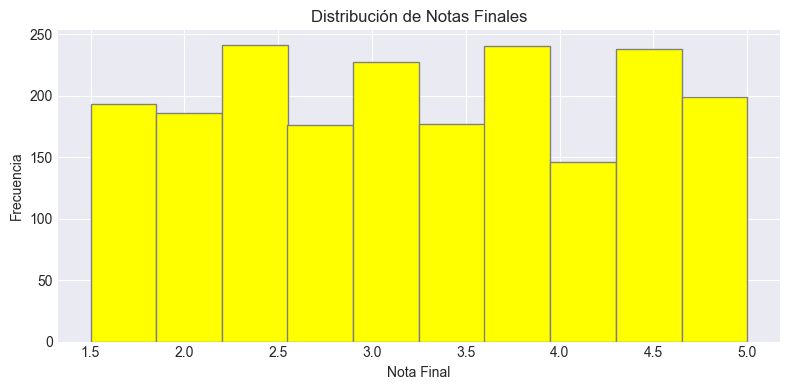

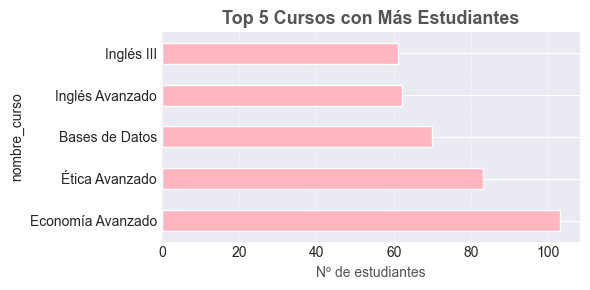

¡Examen Finalizado!


In [38]:
# Espacio para Python / Pandas
# 12. Carga de Datos
db_filename = r"C:\Users\jacks\OneDrive\Escritorio\tareaBD\Datos\universidad.db"   
conn = sqlite3.connect(db_filename)

df_notas = pd.read_sql_query("""
    SELECT  e.nombre      AS nombre_estudiante,
            e.apellido    AS apellido_estudiante,
            c.nombre_curso,
            i.nota_final  AS nota_final,
            p.nombre      AS nombre_profesor
    FROM inscripciones i
    JOIN estudiantes e ON e.id_estudiante = i.id_estudiante
    JOIN cursos      c ON c.id_curso      = i.id_curso
    JOIN profesores  p ON p.id_profesor   = c.id_profesor
    ORDER BY c.nombre_curso, e.apellido, e.nombre;
""", conn)

print("12. Primeras 5 filas y esquema")
display(df_notas.head())
df_notas.info()

# 13. Análisis de Riesgo
df_riesgo = df_notas[df_notas['nota_final'] < 3.0]
print("13. Estudiantes en riesgo (nota < 3.0):", len(df_riesgo))
display(df_riesgo.head())

# 14. Tabla Pivote (Cruce de Variables)
pivot_promedio = df_notas.pivot_table(
    values='nota_final',
    index='nombre_curso',
    columns='nombre_profesor',
    aggfunc='mean'
)
print("14. Promedio de notas por curso y profesor")
display(pivot_promedio.round(2))

# 15. Visualización (Gráfico)
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df_notas['nota_final'].dropna(), bins=10, color='yellow', edgecolor='grey')
ax.set_title('Distribución de Notas Finales')
ax.set_xlabel('Nota Final')
ax.set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Top 5 cursos con más estudiantes (opcional)
top5 = df_notas['nombre_curso'].value_counts().head(5)
fig2, ax2 = plt.subplots(figsize=(6, 3))
top5.plot(kind='barh', ax=ax2,
          color='#FFB6C1',          # rosa pastel
          edgecolor='#FFFFFF', linewidth=1)
ax2.set_title('Top 5 Cursos con Más Estudiantes', fontsize=13, weight='bold', color='#555555')
ax2.set_xlabel('Nº de estudiantes', color='#555555')
ax2.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

conn.close()
print("¡Examen Finalizado!")

